In [2]:
# ✅ Cell 1: Imports and Setup
import os
import pandas as pd
import torch
import torchaudio
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
from jiwer import wer
from pathlib import Path

from transformers import WhisperProcessor, WhisperForConditionalGeneration

# Set project root and paths
PROJECT_ROOT = Path(__file__).resolve().parents[1] if "__file__" in globals() else Path.cwd().parents[1]
DATA_DIR = PROJECT_ROOT / "data" / "zazaki"
MODELS_DIR = PROJECT_ROOT / "models" / "whisper-small"
OUTPUTS_DIR = PROJECT_ROOT / "outputs" / "transcriptions"
OUTPUTS_DIR.mkdir(parents=True, exist_ok=True)


In [3]:
# ✅ Cell 2: Load Whisper-small
whisper_model = WhisperForConditionalGeneration.from_pretrained(
    "openai/whisper-small", cache_dir=str(MODELS_DIR)
).to("cuda")

whisper_processor = WhisperProcessor.from_pretrained(
    "openai/whisper-small", cache_dir=str(MODELS_DIR)
)


In [4]:
# ✅ Cell 3: Load Zazaki Data
tsv_path = DATA_DIR / "dev.tsv"
audio_folder = DATA_DIR / "clips"

df = pd.read_csv(tsv_path, sep="\t")[["path", "sentence"]]
print(f"✅ Loaded {len(df)} Zazaki samples.")


✅ Loaded 463 Zazaki samples.


In [5]:
# ✅ Cell 4: Transcription Function
def transcribe_whisper(filepath):
    try:
        audio, sr = torchaudio.load(filepath)
        audio = torchaudio.functional.resample(audio, sr, 16000)
        inputs = whisper_processor(audio.squeeze().numpy(), sampling_rate=16000, return_tensors="pt").input_features.to("cuda")
        decoder_ids = whisper_processor.get_decoder_prompt_ids(language="tr", task="transcribe")
        predicted_ids = whisper_model.generate(inputs, forced_decoder_ids=decoder_ids)
        return whisper_processor.batch_decode(predicted_ids, skip_special_tokens=True)[0].strip()
    except Exception as e:
        return f"[ERROR] {str(e)}"


In [6]:
# ✅ Cell 5: Transcribe All Samples
results = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    clip_path = audio_folder / row["path"]
    if not clip_path.exists():
        continue

    whisper_pred = transcribe_whisper(str(clip_path))
    results.append({
        "filename": row["path"],
        "ground_truth": row["sentence"],
        "whisper_pred": whisper_pred
    })

df_out = pd.DataFrame(results)
df_out.to_csv(OUTPUTS_DIR / "zazaki_transcription_comparison.csv", index=False)
print("✅ Transcriptions saved to:", OUTPUTS_DIR)


100%|██████████| 463/463 [01:28<00:00,  5.26it/s]

✅ Transcriptions saved to: c:\Users\berfi\Documents\GitHub\dialectalwordmining\outputs\transcriptions


In [7]:
# ✅ Cell 6: Normalize + Compute WER
def normalize_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"[^\w\sçğıöşüêîûâêîôû]", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

df_out_clean = df_out[~df_out["whisper_pred"].str.startswith("[ERROR]")].copy()
df_out_clean["gt_norm"] = df_out_clean["ground_truth"].apply(normalize_text)
df_out_clean["whisper_norm"] = df_out_clean["whisper_pred"].apply(normalize_text)

df_out_clean = df_out_clean[
    (df_out_clean["gt_norm"].str.len() > 0) &
    (df_out_clean["whisper_norm"].str.len() > 0)
]

print(f"✅ {len(df_out_clean)} usable transcriptions.")
whisper_wer = wer(df_out_clean["gt_norm"].tolist(), df_out_clean["whisper_norm"].tolist())
print(f"📊 Normalized Whisper-small WER: {whisper_wer:.3f}")


✅ 463 usable transcriptions.
📊 Normalized Whisper-small WER: 1.048


In [8]:
# ✅ Cell 7: Save Line WER + Unmatched
df_out_clean["whisper_line_wer"] = df_out_clean.apply(
    lambda row: wer(row["gt_norm"], row["whisper_norm"]), axis=1
)

df_unmatched = df_out_clean[
    df_out_clean["gt_norm"] != df_out_clean["whisper_norm"]
]

df_unmatched.to_csv(OUTPUTS_DIR / "unmatched_records_zazaki.csv", index=False)
print(f"🔍 Saved {len(df_unmatched)} unmatched Whisper records.")


🔍 Saved 461 unmatched Whisper records.


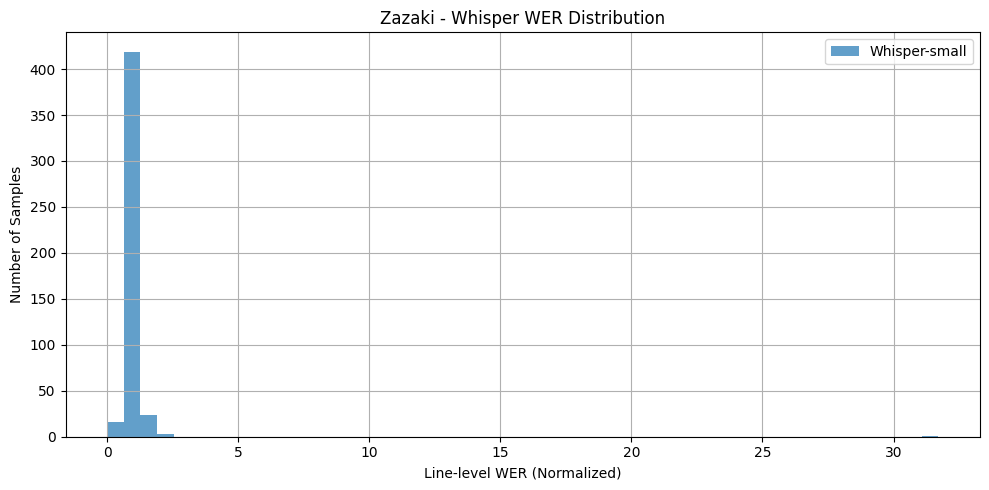

In [9]:
# ✅ Cell 8: Histogram
plt.figure(figsize=(10, 5))
plt.hist(df_out_clean["whisper_line_wer"], bins=50, alpha=0.7, label="Whisper-small")
plt.xlabel("Line-level WER (Normalized)")
plt.ylabel("Number of Samples")
plt.title("Zazaki - Whisper WER Distribution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
